# Segmentation example
This segmentation example shows a workflow to develop a model,
and use base + mask images of boundaries to train an AI to detect the boundaries.

The model results are terrible, as we will be developing the actual model during our construciton phase,
but this provides a valid technical demonstrator of the overall process.

In [80]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import tensorflow as tf
import cv2 as cv

from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply, BatchNormalization, Conv2DTranspose, Concatenate
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from IPython.display import Image, clear_output
from tensorflow import keras
from keras import backend as K

import pandas as pd

In [81]:
# Constants

img_shape = (512, 512)
batch_size = 4
num_test = 15;

In [82]:
# Get all data

# Go to the data folder, its split into "Areas"
# For every folder in the areas, get their img and label folders

DATA_DIR = './images/penrith_test/'
sat_image = []
mask_image = []

for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        fp = os.path.join(subdir, file)
        if(subdir[-3:] == 'img'):
            sat_image.append(fp)
        elif(subdir[-3:] == 'lbl'):
            mask_image.append(fp)
            
test_img = sat_image[-num_test:]
test_mask = mask_image[-num_test:]

sat_image = sat_image[0:-num_test]
mask_image = mask_image[0:-num_test]

In [83]:
len(sat_image), len(mask_image)

(739, 739)

In [84]:
# Add to datafram
df = pd.DataFrame({
    'Image' : sat_image,
    'Mask' : mask_image
})

df

Image  \
0      ./images/penrith_test/Area1\img\output_1.tiff   
1     ./images/penrith_test/Area1\img\output_10.tiff   
2    ./images/penrith_test/Area1\img\output_100.tiff   
3     ./images/penrith_test/Area1\img\output_11.tiff   
4     ./images/penrith_test/Area1\img\output_12.tiff   
..                                               ...   
734   ./images/penrith_test/Area4\img\output_81.tiff   
735   ./images/penrith_test/Area4\img\output_82.tiff   
736   ./images/penrith_test/Area4\img\output_83.tiff   
737   ./images/penrith_test/Area4\img\output_84.tiff   
738   ./images/penrith_test/Area4\img\output_85.tiff   

                                                Mask  
0      ./images/penrith_test/Area1\lbl\output_1.tiff  
1     ./images/penrith_test/Area1\lbl\output_10.tiff  
2    ./images/penrith_test/Area1\lbl\output_100.tiff  
3     ./images/penrith_test/Area1\lbl\output_11.tiff  
4     ./images/penrith_test/Area1\lbl\output_12.tiff  
..                                               ...  
734   ./images/penrith_test/Area4\lbl\output_81.tiff  
735   ./images/penrith_test/Area4\lbl\output_82.tiff  
736   ./images/penrith_test/Area4\lbl\output_83.tiff  
737   ./images/penrith_test/Area4\lbl\output_84.tiff  
738   ./images/penrith_test/Area4\lbl\output_85.tiff  

[739 rows x 2 columns]

In [85]:
def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

In [86]:
def map_function(img, mask):
    img = cv.imread(img.decode())
    mask = cv.imread(mask.decode(), cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, img_shape)
    mask = modify_mask(cv.resize(mask, img_shape))
    img = img/255.0

    return img.astype(np.float64), mask.astype(np.float64)

In [87]:
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

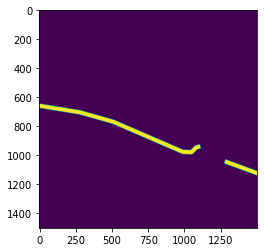

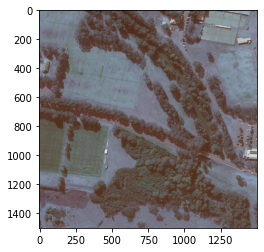

In [88]:
img = cv.imread(mask_image[0], cv.IMREAD_GRAYSCALE)
plt.imshow(modify_mask(img))
plt.show()
img = cv.imread(sat_image[0])
plt.imshow(img)
plt.show()

In [89]:
# Create the actual dataset used during training
train_dataset = create_dataset(df)
img, mask = next(iter(train_dataset))
img.shape, mask.shape

(TensorShape([4, 512, 512, 3]), TensorShape([4, 512, 512, 1]))

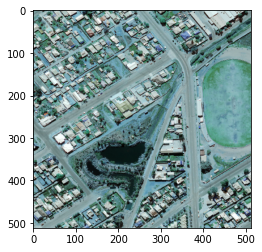

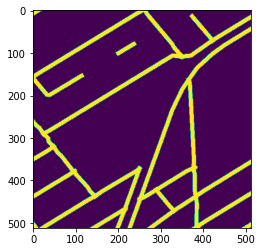

In [90]:
plt.imshow(img[2])
plt.show()
plt.imshow(mask[2])
plt.show()

In [91]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Setup the model
From https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/segmentation_unet-three-plus_oxford-iiit.ipynb

In [92]:
def unet(num_classes = 1, input_shape= (img_shape[0],img_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  
 
  
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
 
  model = Model(inputs=inp, outputs=x)
  adam = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(optimizer=adam,
                  loss=dice_coef_loss,
                  metrics=[dice_coef])
    # model.summary()
  return model

## Compile the model

In [93]:
model = unet()

C:\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Show functions
These functions allow the images to be displayed
We also show the predictions before the model is trained

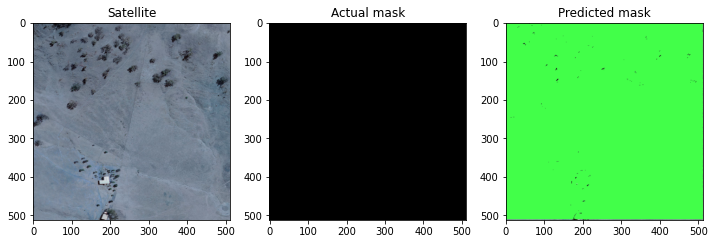

In [94]:
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def display(img, mask):
    plt.figure(figsize = (12,10))
    
    mask = modify_mask(cv.resize(mask, img_shape))
    img = (img/255.0)

    img = np.expand_dims(cv.resize(img, img_shape), 0)
    img = img.astype(np.float32)
    
    pred = make_pred_good(model(img))
    mask = make_pred_good(np.expand_dims(mask, axis = 0))
    
    plt.subplot(1,3,1)
    plt.title("Satellite")
    plt.imshow(img[0])
    plt.subplot(1,3,2)
    plt.title('Actual mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    pred = placeMaskOnImg(img[0], pred)
    plt.imshow(pred)
    
    plt.show()
    
n = 1
    
display(cv.imread(test_img[2]), cv.imread(test_mask[2], cv.IMREAD_GRAYSCALE))

In [95]:
def showHistory(mh):
    # summarize history for accuracy
    plt.plot(mh.history['dice_coef'])
    plt.title('Dice coef')
    plt.ylabel('coef')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(mh.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Define callbacks
These callbacks are run after each epoch
They show the current prediction result and save the model

In [99]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        for i in range(num_test):
            display(cv.imread(test_img[i]), cv.imread(test_mask[i], cv.IMREAD_GRAYSCALE))
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    keras.callbacks.ModelCheckpoint('./512_model_allAussie_A1234.h5', monitor="loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30),
    DisplayCallback()
]

In [100]:
 #Load the current best model
model = load_model('./512_model_allAussie_A1234.h5', compile=True, custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

# Train the model

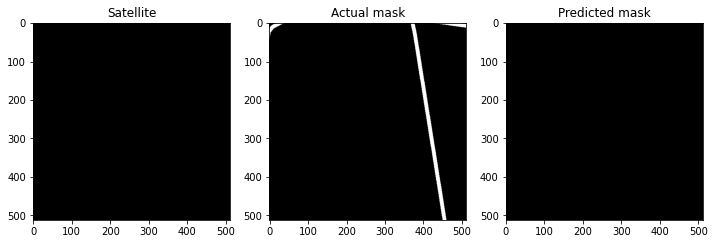

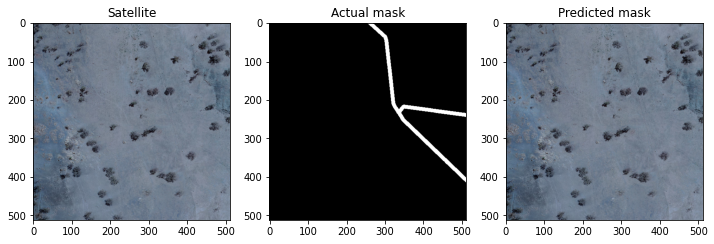

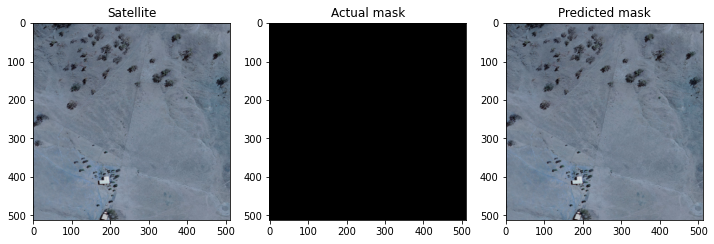

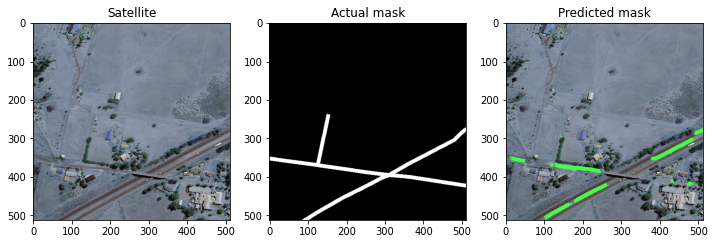

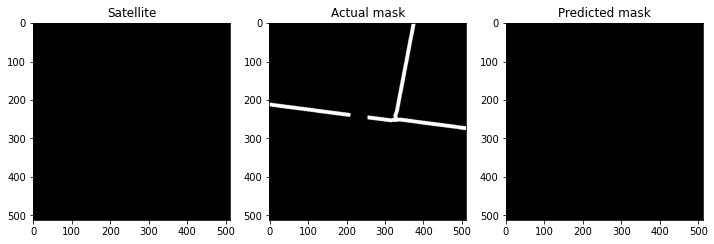

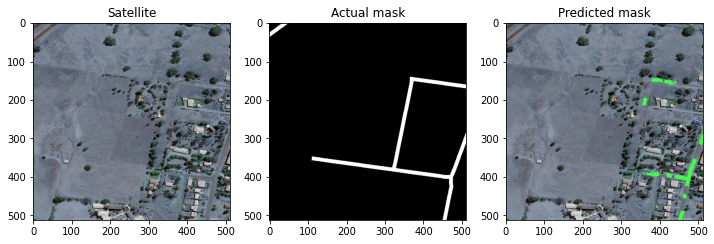

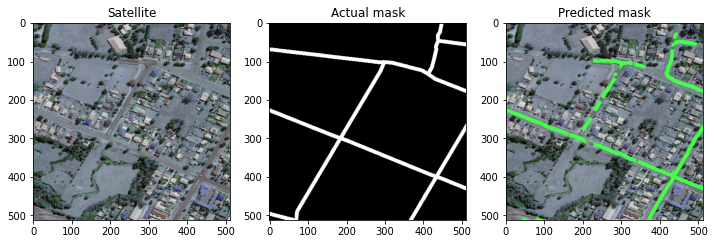

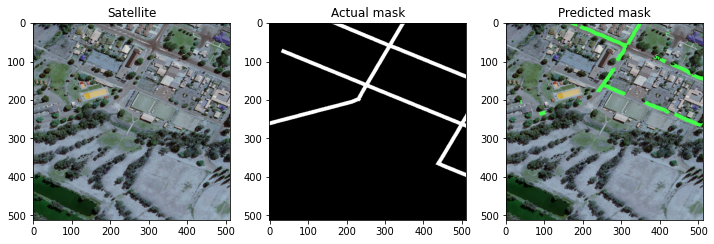

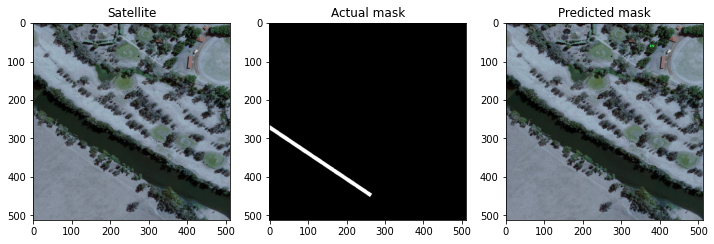

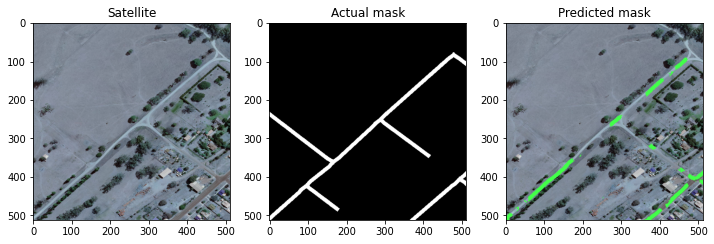

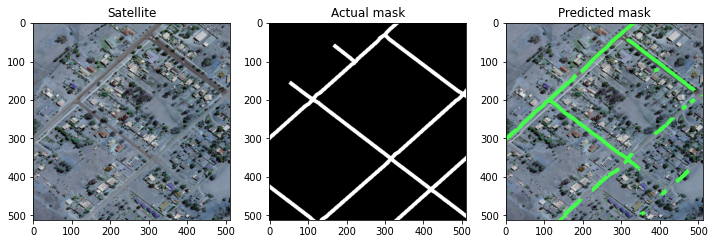

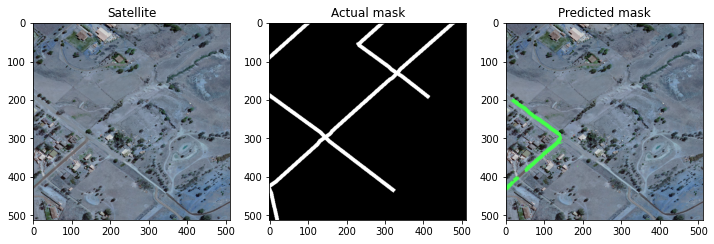

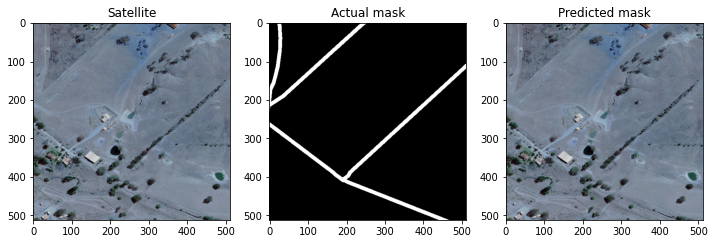

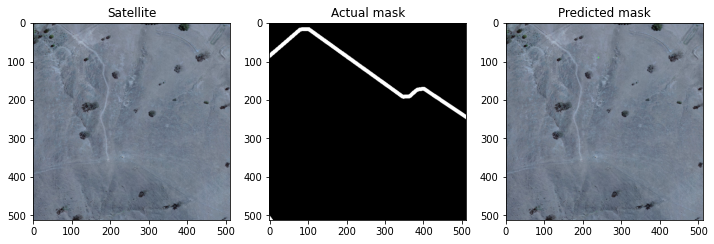

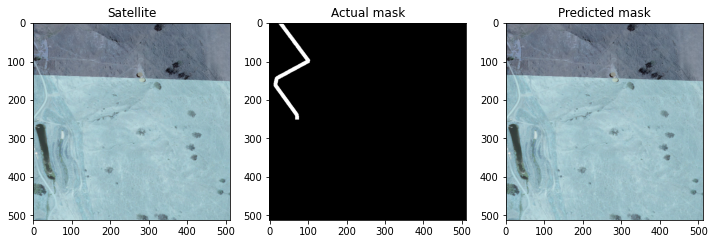


Sample Prediction after epoch 300

185/185 [==============================] - 73s 391ms/step - loss: 0.0616 - dice_coef: 0.9385


In [101]:
EPOCHS = 300

model_history = model.fit(train_dataset,
                          callbacks=callbacks,
                          epochs=EPOCHS)

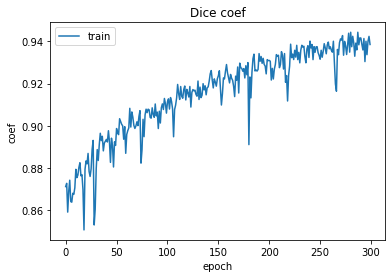

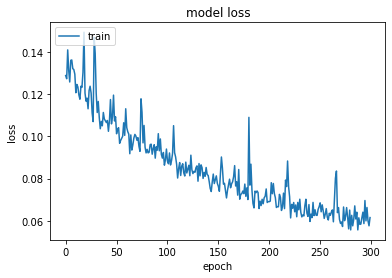

In [102]:
# summarize history for accuracy
plt.plot(model_history.history['dice_coef'])
plt.title('Dice coef')
plt.ylabel('coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
## Load the best weights
model = load_model('./512_model_allAussie_A1234.h5', compile=False)

In [104]:
## Show some predictions using our trained model

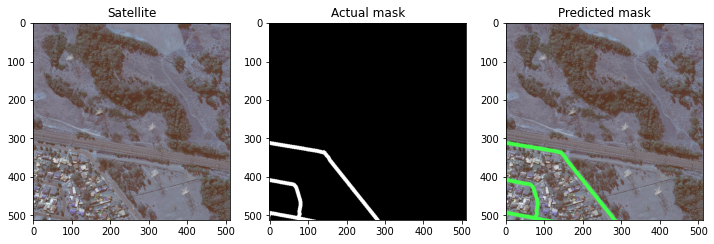

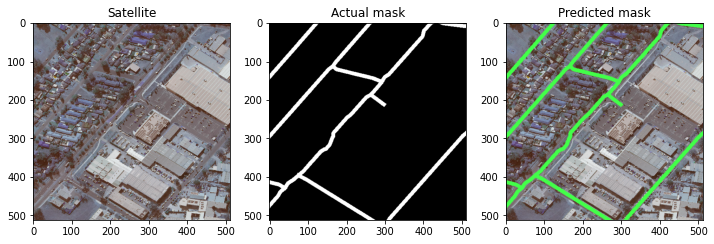

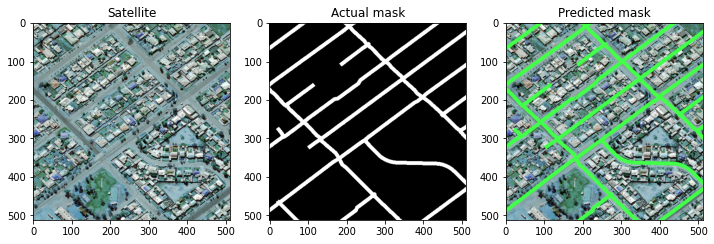

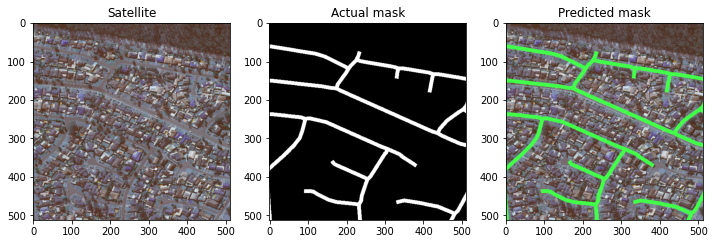

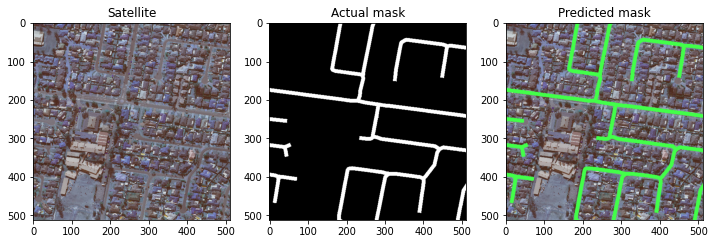

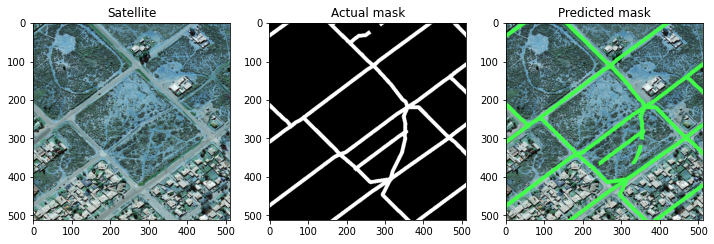

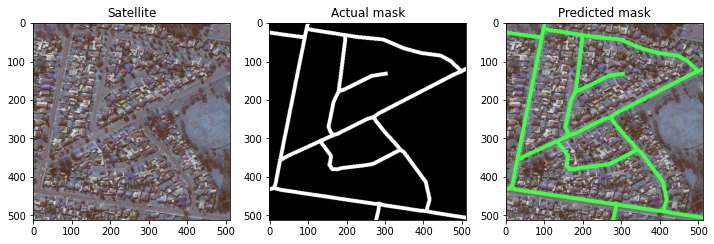

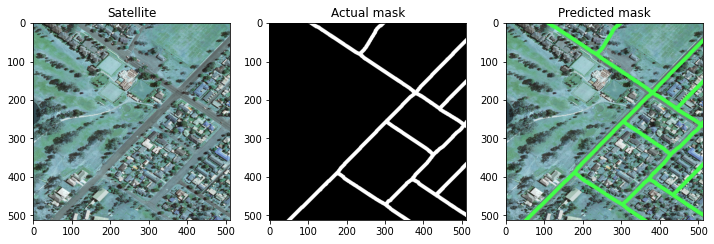

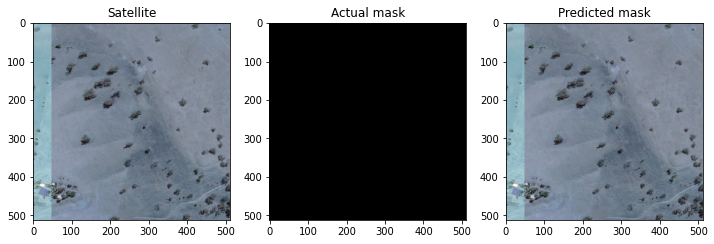

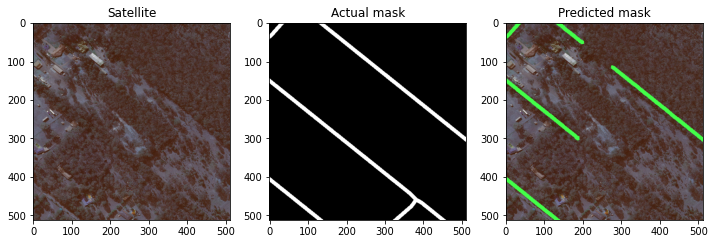

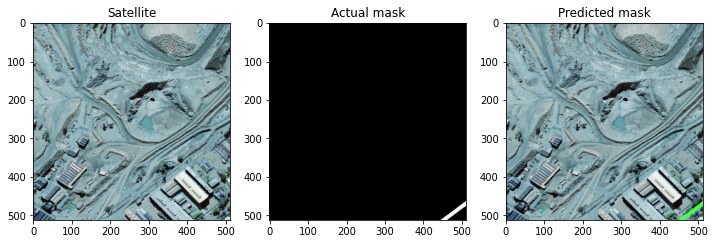

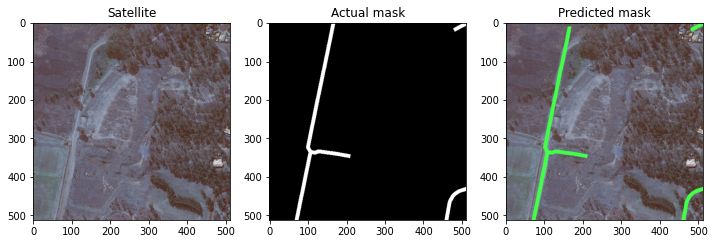

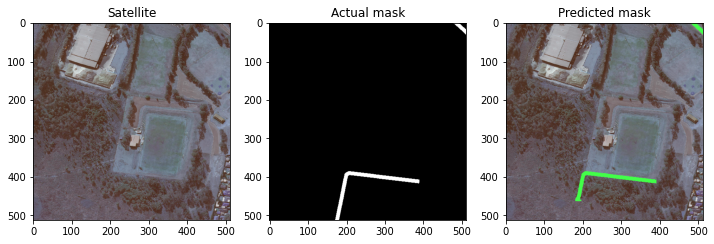

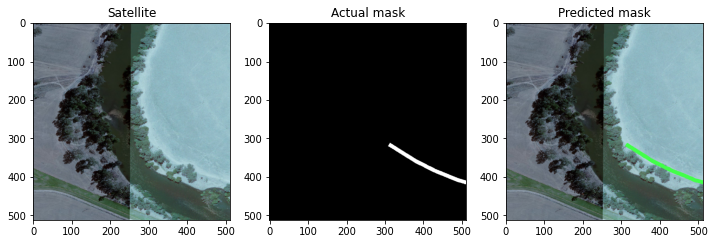

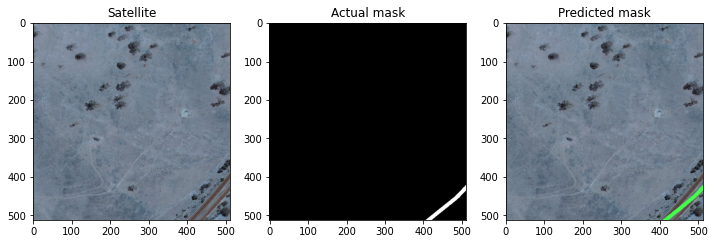

In [107]:
import random
zipped = list(zip(sat_image, mask_image))
random.shuffle(zipped)
res1, res2 = zip(*zipped)

for i in range(num_test):
    display(cv.imread(res1[i]), cv.imread(res2[i], cv.IMREAD_GRAYSCALE))